In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

In [3]:
inWidth = 368
inHeight = 368
thr = 0.2

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [5]:
img = cv.imread("image.jpg")

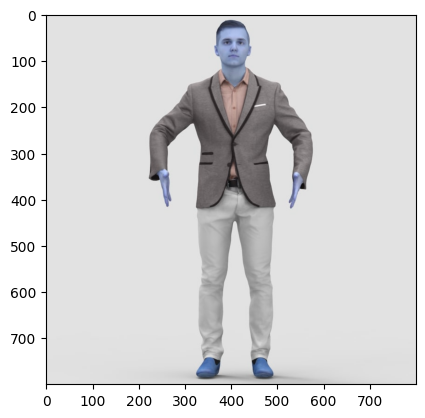

In [6]:
plt.imshow(img)

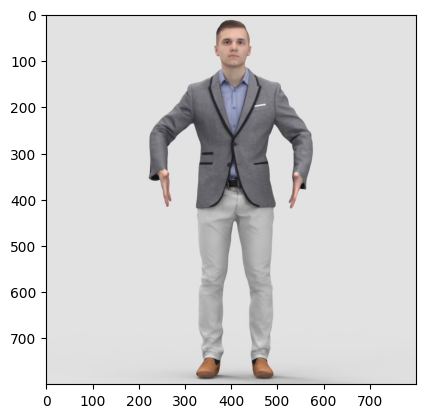

In [7]:
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

In [8]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Prepare input blob for the network
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # Keep only the first 19 outputs (body parts)

    # Ensure the output matches the expected BODY_PARTS
    assert len(BODY_PARTS) == out.shape[1]

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap for the current body part
        heatMap = out[0, i, :, :]

        # Find global maximum on the heatmap
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if confidence is above the threshold
        points.append((int(x), int(y)) if conf > thr else None)

    # Draw connections between body parts
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert partFrom in BODY_PARTS
        assert partTo in BODY_PARTS

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    # Display inference time
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return frame

In [9]:
estimated_image = pose_estimation(img)

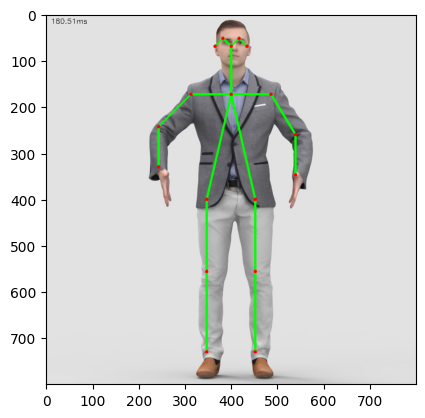

In [10]:
plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

In [11]:
#real time 

In [16]:
cap = cv.VideoCapture(1)

cap.set(cv.CAP_PROP_FPS,10)
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("cannot open webcam")
while cv.waitKey(1)<0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Prepare input blob for the network
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # Keep only the first 19 outputs (body parts)

    # Ensure the output matches the expected BODY_PARTS
    assert len(BODY_PARTS) == out.shape[1]

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap for the current body part
        heatMap = out[0, i, :, :]

        # Find global maximum on the heatmap
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if confidence is above the threshold
        points.append((int(x), int(y)) if conf > thr else None)

    # Draw connections between body parts
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert partFrom in BODY_PARTS
        assert partTo in BODY_PARTS

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    # Display inference time
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('pose estimation ',frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        print("Exiting on user request...")
        break

cap.release()
cv.destroyAllWindows()
        